In [1]:
import os
import bye_cycle
import tensorflow as tf
# Disabling tf warnings
tf.get_logger().setLevel('INFO')
from tqdm import tqdm
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from beep.structure.cli import auto_load_processed
import random
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import seaborn as sns

Num GPUs Available:  1


In [2]:
input_window_size = 50
output_window_size = 50
pkl_f_l_filename = f'CACHED_DATA/pickled_cycle_windows/LFP/fearures_labels_inputs_window_{input_window_size}_outputs_window_{output_window_size}.pkl'
with open(pkl_f_l_filename, 'rb') as f:
    [cell_features, cell_labels] = pkl.load(f)  

In [3]:
scaled_X_train_time_series, scaled_slopes_train, scaled_X_val_time_series, scaled_slopes_val, scaled_X_test_time_series, scaled_slopes_test, f_scaler, l_scaler = bye_cycle.process_data(cell_features, cell_labels, seed=0, train_size=0.9, val_size=0.2)

Train size:100
Validation size:25
Test size:14
Total cells: 139


In [4]:
hyper_params = bye_cycle.DegredationModelHyperParams(reg_strength=0)

model = bye_cycle.DegredationModel(hyper_params)
model.compile()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 100, 2)]      0         
                                                                 
 time_distributed (TimeDistr  (None, 50, 1, 32)        6432      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 1, 32)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 32)           0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 64)           16640     
 l)                                                          

In [5]:
model.fit(scaled_X_train_time_series, scaled_slopes_train,
          validation_data=(scaled_X_val_time_series, scaled_slopes_val), verbose=0, epochs=200)

Text(0.5, 0, 'Epochs')

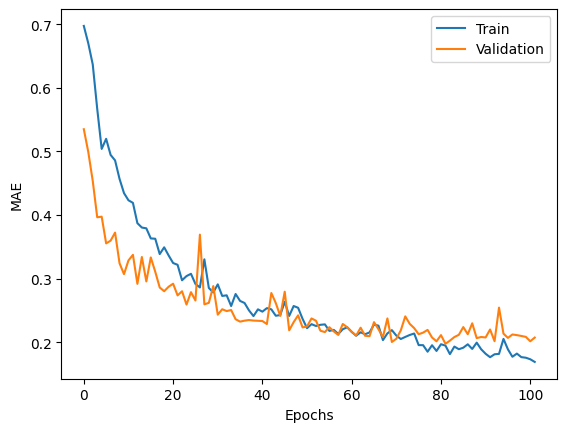

In [6]:
plt.figure(dpi=100, facecolor='white')
plt.plot(model.history.history['loss'], color='C0', label='Train')
plt.plot(model.history.history['val_loss'], color='C1', label='Validation')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Epochs')

In [7]:
slope_mae = model.evaluate(scaled_X_test_time_series, scaled_slopes_test)
Y_hat_test_scaled = model.predict(scaled_X_test_time_series)
Y_hat_test = l_scaler.inverse_transform(Y_hat_test_scaled)
slopes_test = l_scaler.inverse_transform(scaled_slopes_test)

6/6 [==============================] - 1s 13ms/step


(0.0, 110.0)

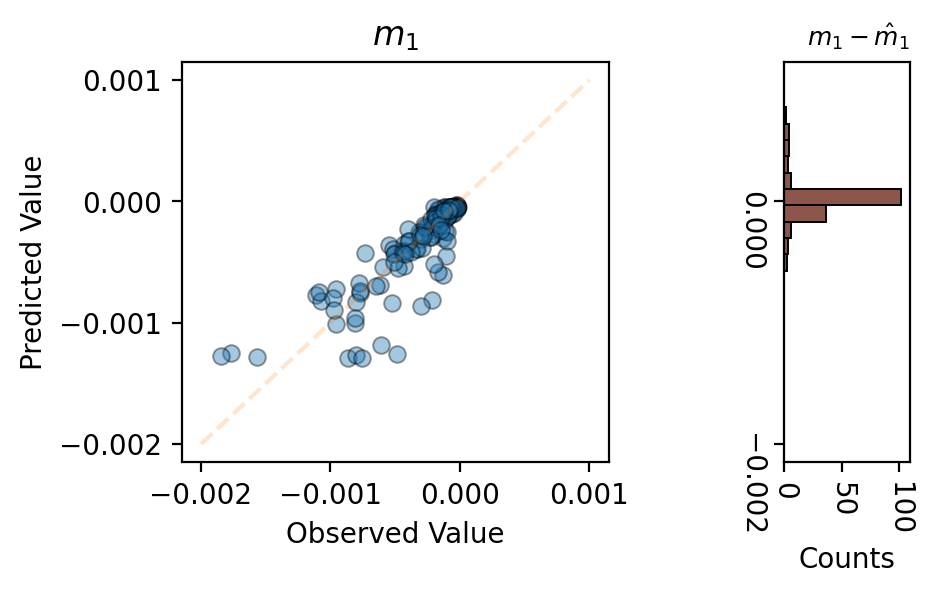

In [8]:
from matplotlib.gridspec import GridSpec
gs = GridSpec(5,5, hspace=5)
fig = plt.figure(figsize=(4.7, 5), dpi=200, facecolor='white')
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,4])

ax_joint.scatter(slopes_test[:,0], Y_hat_test[:,0], alpha=0.4, edgecolor='k', linewidth=0.7)
ax_joint.plot([-0.002,0.001], [-0.002,0.001], color='C1', alpha=0.2, linestyle='--')
ax_joint.set_title(r'$m_1$')
ax_joint.set_xlabel('Observed Value')
ax_joint.set_ylabel('Predicted Value')
ax_joint.locator_params(nbins=4)
ymin, ymax = ax_joint.get_ylim()

err = slopes_test[:,0] - Y_hat_test[:,0]
ax_marg_y.hist(err, bins=10, orientation="horizontal", edgecolor='black', linewidth=0.7, color ='C5');
ax_marg_y.set_xlabel('Counts')
ax_marg_y.set_title(r'$m_1 - \hat{m}_1$', fontsize=9, loc='right')

ax_marg_y.tick_params(rotation=-90)
ax_marg_y.locator_params(nbins=3)
ax_marg_y.set_ylim([ymin, ymax])
ax_marg_y.set_xlim([0, 110])

(-0.00215, 0.00115)

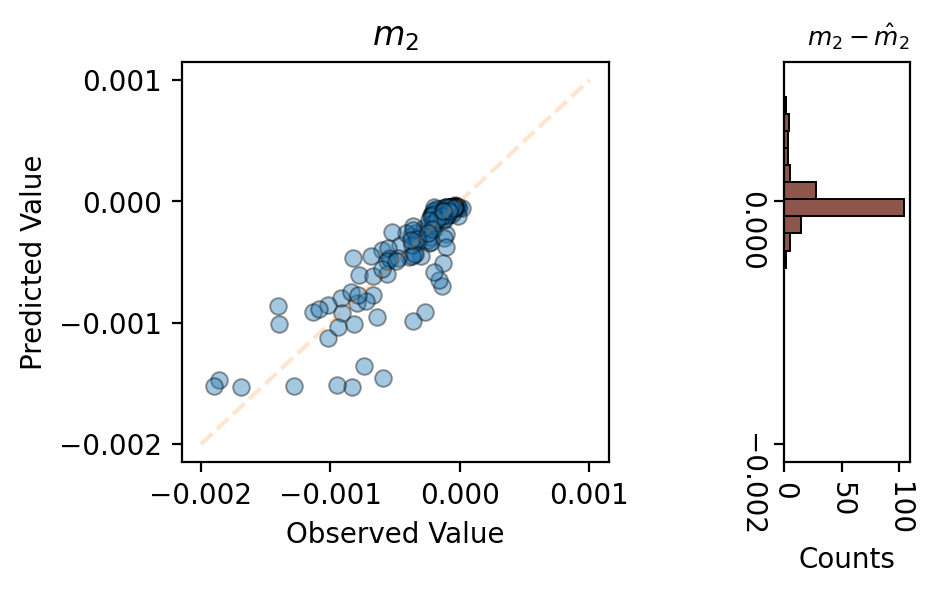

In [9]:
gs = GridSpec(5,5, hspace=5)
fig = plt.figure(figsize=(4.7, 5), dpi=200, facecolor='white')
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,4])

ax_joint.scatter(slopes_test[:,1], Y_hat_test[:,1], alpha=0.4, edgecolor='k', linewidth=0.7)
ax_joint.plot([-0.002,0.001], [-0.002,0.001], color='C1', alpha=0.2, linestyle='--')
ax_joint.set_title(r'$m_2$')
ax_joint.set_xlabel('Observed Value')
ax_joint.set_ylabel('Predicted Value')
ax_joint.locator_params(nbins=4)
ymin, ymax = ax_joint.get_ylim()

err = slopes_test[:,1] - Y_hat_test[:,1]
ax_marg_y.hist(err, bins=10, orientation="horizontal", edgecolor='black', linewidth=0.7, color ='C5');
ax_marg_y.set_xlabel('Counts')
ax_marg_y.set_title(r'$m_2 - \hat{m}_2$', fontsize=9, loc='right')

ax_marg_y.tick_params(rotation=-90)
ax_marg_y.locator_params(nbins=3)
ax_marg_y.set_ylim([ymin, ymax])


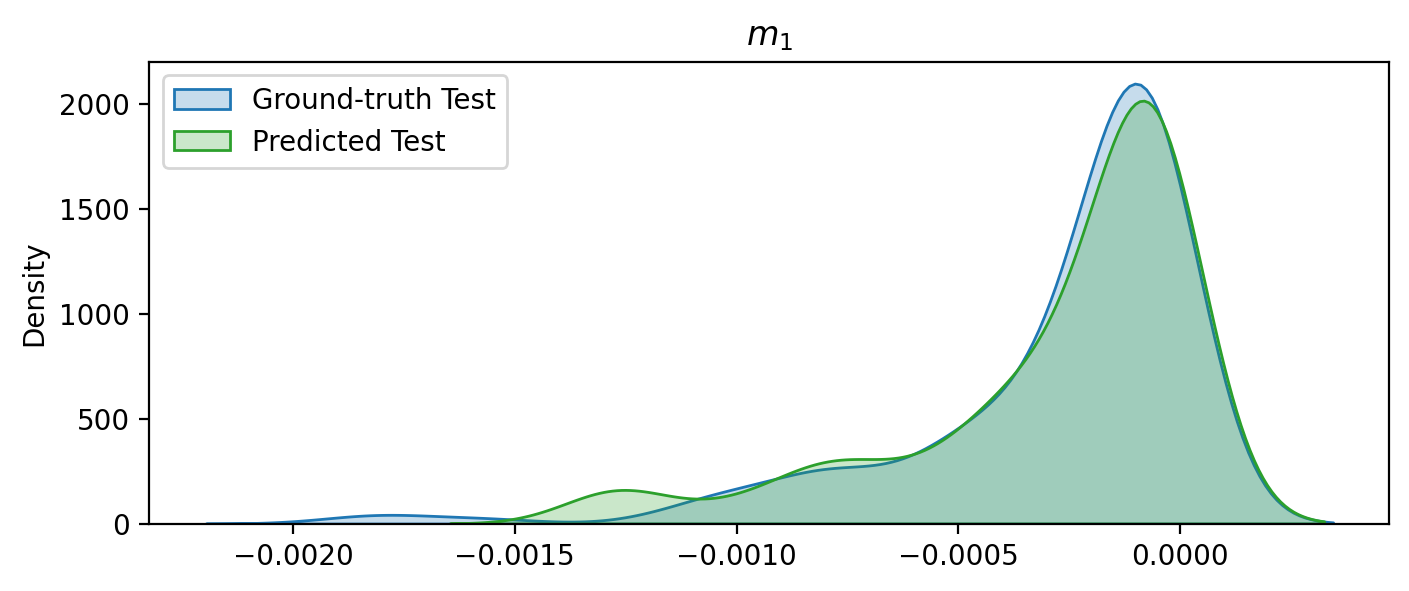

In [10]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
sns.kdeplot(slopes_test[:,0], alpha=0.25, label='Ground-truth Test', color='C0', fill=True)
sns.kdeplot(Y_hat_test[:,0],  alpha=0.25, label='Predicted Test', color='C2', fill=True)
ax.set_title(r'$m_1$')
plt.legend(loc='upper left')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()

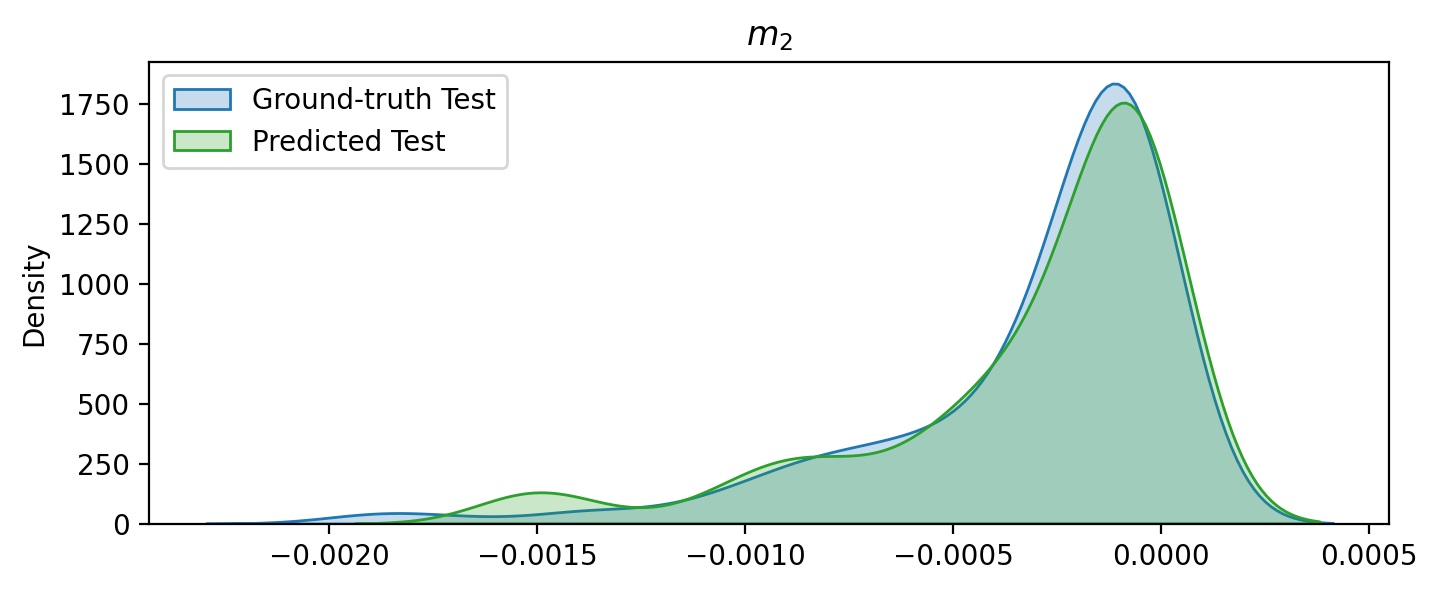

In [11]:
fig, ax = plt.subplots(1, dpi=200, figsize=(8,3), facecolor='white')
sns.kdeplot(slopes_test[:,1], alpha=0.25, label='Ground-truth Test', color='C0', fill=True)
sns.kdeplot(Y_hat_test[:,1],  alpha=0.25, label='Predicted Test', color='C2', fill=True)
ax.set_title(r'$m_2$')
plt.legend(loc='upper left')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()